In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import pandas as pd

from collections import Counter
from pathlib import Path

from lynx_id.data.dataset import LynxDataset
from lynx_id.data.transformations_and_augmentations import transforms
from torch.utils.data import DataLoader
from lynx_id.data.collate import collate_single
from lynx_id.model.embeddings import EmbeddingModel
from lynx_id.model.clustering import ClusteringModel, location_lynx_image

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE=}")

DEVICE='cuda'


In [4]:
IMAGE_FOLDER = Path("/gpfswork/rech/ads/uxp55sd/test_scripts/data")

In [5]:
dataset = LynxDataset(
    folder_path_images=IMAGE_FOLDER,
    loader='pil',
    transform=transforms,
    probabilities=[1, 0, 0],
    mode='single',
    device='auto'
)

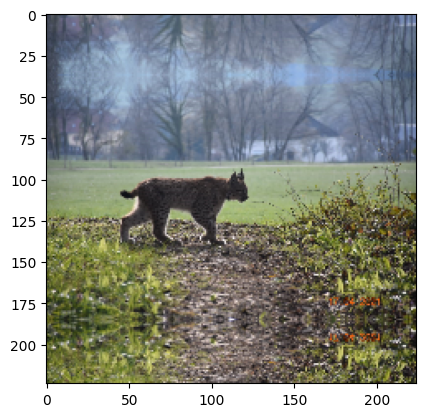

In [6]:
plt.imshow(dataset[1][0]['image'].permute(1,2,0))

In [7]:
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single
)

In [8]:
embedding_model = EmbeddingModel(
    model_path="/gpfswork/rech/ads/uxp55sd/downloaded_model/model_best_0.512.pth",
    device=DEVICE
) 

/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/torchvision-0.16.1+fdea156-py3.11-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/torchvision-0.16.1+fdea156-py3.11-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
embeddings = embedding_model.compute_embeddings(dataloader)

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


In [10]:
embeddings.shape

torch.Size([2, 2048])

In [11]:
clustering_model = ClusteringModel(
    embeddings_knowledge="/gpfswork/rech/ads/uxp55sd/test_scripts/knowledge_db/embeddings.safetensors",
    lynx_infos_knowledge="/gpfswork/rech/ads/uxp55sd/test_scripts/knowledge_db/embeddings.csv",
    n_neighbors=5,
    algorithm="brute",
    metric="minkowski",
)

In [12]:
candidates_nearest_neighbors = clustering_model.clustering(embeddings.cpu())

In [13]:
candidates_nearest_neighbors

[[B439, F39-060, B583_Kassandra, B11_Kika_Silva_Juv.08, B224_Nora],
 [409, 2125, 2125, B287_Moritz, F39-086=1474=1478]]

In [14]:
clustering_model.distances

array([[2.78552090e-06, 6.88139618e-01, 7.19286635e-01, 7.29099071e-01,
        7.36202847e-01],
       [1.24970771e+00, 1.32406795e+00, 1.33039223e+00, 1.33387195e+00,
        1.36932925e+00]])

In [15]:
clustering_model.one_knn()

[B439, 409]

In [16]:
clustering_model.one_knn()[0].date

Timestamp('2017-09-20 00:00:00')

In [17]:
clustering_model.n_knn()

[B439, 2125]

In [19]:
candidates_predicted_new_individual = clustering_model.check_new_individual(
    candidates_predicted=clustering_model.one_knn(),
    threshold=0.5,
)

In [20]:
candidates_predicted_new_individual

[B439, New]

In [21]:
updated_candidates_nearest_neighbors = clustering_model.compute_candidates_nearest_neighbors_new(candidates_predicted_new_individual)

In [22]:
updated_candidates_nearest_neighbors

[[B439, F39-060, B583_Kassandra, B11_Kika_Silva_Juv.08, B224_Nora],
 [New, 409, 2125, 2125, B287_Moritz]]

In [25]:
clustering_model.most_recent_date_lynx_id(candidates_predicted_new_individual)

[Timestamp('2020-04-28 00:00:00'), None]

In [26]:
output_results_nearest = pd.DataFrame(updated_candidates_nearest_neighbors, columns=["neighbor_1", "neighbor_2", "neighbor_3", "neighbor_4", "neighbor_5"])
output_results_nearest

neighbor_1 neighbor_2      neighbor_3             neighbor_4   neighbor_5
0       B439    F39-060  B583_Kassandra  B11_Kika_Silva_Juv.08    B224_Nora
1        New        409            2125                   2125  B287_Moritz

In [27]:
output_results_prediction = pd.DataFrame(
    {
        "filepath": dataset.dataframe.filepath.tolist(),
        "individual_predicted": candidates_predicted_new_individual,
        "latest_picture_individual_predicted": clustering_model.most_recent_date_lynx_id(candidates_predicted_new_individual),
        "location": location_lynx_image(candidates_predicted_new_individual)

    }
)
output_results_prediction

filepath individual_predicted  \
0  /gpfswork/rech/ads/uxp55sd/test_scripts/data/B...                 B439   
1  /gpfswork/rech/ads/uxp55sd/test_scripts/data/2...                  New   

  latest_picture_individual_predicted  location  
0                          2020-04-28       NaN  
1                                 NaT       NaN

In [28]:
pd.concat([output_results_prediction, output_results_nearest], axis=1)

filepath individual_predicted  \
0  /gpfswork/rech/ads/uxp55sd/test_scripts/data/B...                 B439   
1  /gpfswork/rech/ads/uxp55sd/test_scripts/data/2...                  New   

  latest_picture_individual_predicted  location neighbor_1 neighbor_2  \
0                          2020-04-28       NaN       B439    F39-060   
1                                 NaT       NaN        New        409   

       neighbor_3             neighbor_4   neighbor_5  
0  B583_Kassandra  B11_Kika_Silva_Juv.08    B224_Nora  
1            2125                   2125  B287_Moritz

In [29]:
dataset.dataframe.filepath.tolist()

['/gpfswork/rech/ads/uxp55sd/test_scripts/data/B439_OCS_NA_2017-09-20_NA_4.JPG',
 '/gpfswork/rech/ads/uxp55sd/test_scripts/data/2327_OFB_OCELLES_2021-04-17_Saint-Gorgon-Main_2.jpg']